## Executive Summary

**Project Goals**

**Data summary**


**Modules**
- acquire.py: Turns the salary data into a pandas dataframe.
- prepare.py: Takes the salary dataframe and generally clean removing and adding columns. This also holds a scaler and train/validate/test split.
- wrangle.py: Brings both the acquire and prepare functions together.
- explore.py: Holds functions to explore and visualize the data.
- model.py: Contains models and useful plotting tools to visualize model accuracy.

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from acquire import get_salary_data
from prepare import clean_salary_data, min_max_scaler, train_validate_test
from wrangle import wrangle_salary_data, wrangle_explore_salary_data
from explore import salary_heatmap,plot_categorical_and_continuous_vars,plot_hist
from model import make_metric_df,make_metric_df_train

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import TweedieRegressor
from sklearn.tree import DecisionTreeRegressor

import graphviz
from graphviz import Graph

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['savefig.dpi'] = 300
%matplotlib inline
sns.set_style("darkgrid")

### Acquire

In [3]:
df = get_salary_data()

In [4]:
# Here's a look at the unclean dataframe
df.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
3,6/17/2017 0:23:14,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
4,6/20/2017 10:58:51,Microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,NaN,0.0,...,0,0,0,0,0,0,0,0,NaN,NaN


In [5]:
df.shape

(62642, 29)

In [6]:
# We can see some null values, and several string values, that will need to be changed/removed.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62642 entries, 0 to 62641
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                62642 non-null  object 
 1   company                  62637 non-null  object 
 2   level                    62523 non-null  object 
 3   title                    62642 non-null  object 
 4   totalyearlycompensation  62642 non-null  int64  
 5   location                 62642 non-null  object 
 6   yearsofexperience        62642 non-null  float64
 7   yearsatcompany           62642 non-null  float64
 8   tag                      61788 non-null  object 
 9   basesalary               62642 non-null  float64
 10  stockgrantvalue          62642 non-null  float64
 11  bonus                    62642 non-null  float64
 12  gender                   43102 non-null  object 
 13  otherdetails             40137 non-null  object 
 14  cityid                

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
totalyearlycompensation,62642.0,216300.373647,138033.746377,10000.0,135000.00,188000.0,264000.00,4980000.0
yearsofexperience,62642.0,7.204135,5.840375,0.0,3.00,6.0,10.00,69.0
yearsatcompany,62642.0,2.702093,3.263656,0.0,0.00,2.0,4.00,69.0
basesalary,62642.0,136687.281297,61369.278057,0.0,108000.00,140000.0,170000.00,1659870.0
stockgrantvalue,62642.0,51486.080733,81874.569391,0.0,0.00,25000.0,65000.00,2800000.0
bonus,62642.0,19334.746588,26781.292040,0.0,1000.00,14000.0,26000.00,1000000.0
cityid,62642.0,9856.201989,6679.104563,0.0,7369.00,7839.0,11521.00,47926.0
dmaid,62640.0,616.097222,289.843390,0.0,506.00,807.0,807.00,881.0
rowNumber,62642.0,41694.723732,24488.865879,1.0,20069.25,42019.0,63021.75,83875.0
Masters_Degree,62642.0,0.245698,0.430504,0.0,0.00,0.0,0.00,1.0


### Prepare
**General Breakdown**

- Breakdown of my prep for my models prepare/clean function:
    - Function creates a dummy variable for title and concats it with the current dataframe.
    - Drops columns that are not useful, or would make the dataset too large to use dummies on.
    - Drops nulls, removes any rows that do not have education documented.
    - Renames some columns for readability.
    - Adds a column for highly experienced.
    
- Breakdown of my prep for my explore prepare/clean fucntion:
    - Creates dummy variable for gender.
    - Removes some columns I do not want insite about or that contain to many nulls.
    - Drops nulls, removes any rows that do not have education documented.
    - Renames some columns for readability.
    - Adds a column for highly experienced.

**The reason that there are two data clean functions is because they contain the same data, although I wanted some deeper exploration into some extra variables that couldnt be translated into my model given the timeframe.**

### Wrangle

In [9]:
df_explore, train_explore, validate_explore, test_explore = wrangle_explore_salary_data()

In [10]:
df, train, validate, test, X_train, X_train_scaled , y_train, X_validate, X_validate_scaled , y_validate, X_test, X_test_scaled , y_test, scaler = wrangle_salary_data()

In [11]:
# A look at our cleaned dataframe
df.head()

,total_earnings,yearsofexperience,yearsatcompany,cityid,masters_degree,bachelors_degree,doctorate_degree,highschool,some_college,title_business_analyst,...,title_mechanical_engineer,title_product_designer,title_product_manager,title_recruiter,title_sales,title_software_engineer,title_software_engineering_manager,title_solution_architect,title_technical_program_manager,highly_experienced
46,320000,4.0,1.0,7419,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
717,239000,4.0,0.0,7300,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3427,125000,1.0,0.0,40303,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5037,170000,0.0,0.0,10182,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5392,332000,1.0,0.0,7351,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df.shape

(29946, 25)

In [13]:
train.shape

(17967, 25)

In [14]:
validate.shape

(5989, 25)

In [15]:
test.shape

(5990, 25)

Initial dataset has 62642 rows, and 29 columns. After cleaning the dataset has 29946 rows, and 25 columns

### Explore

### Hypotheses
1. Do male tech employees make more money then female
2. Does education level correlated to higher wages
3. Do employees that stay with one company make more money then those that change companies, with the same experience
4. Does location correlate with earnings.
5. Are some job titles only held by those with higher education(masters or doctorate degrees).

<AxesSubplot:title={'center':'Features Correlating with total_earnings'}>

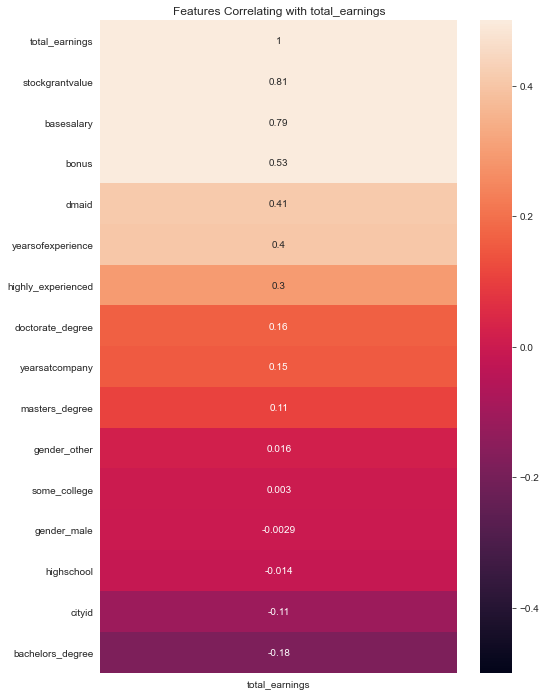

In [16]:
# Lets take a look at a correlation heatmap
salary_heatmap(df_explore,target = 'total_earnings')

**Takeaways**
- Since stockgrantvalue, base salary bonus and dmaid have a relationship with our target variable total earnings they will have to be removed.


- Top 3 positive correlating features:
    - Years of experience
    - having a doctorate degree
    - Years at a company
- Top 3 negative correlating features:
    - Having a bachelors degree
    - location
    - Having highschool as the highest education

### Univariate exploration

In [17]:
col_list = train.columns.to_list()

total_earnings
count     17967.000000
mean     198127.511549
std      106828.061454
min       10000.000000
25%      125000.000000
50%      180000.000000
75%      250000.000000
max      608000.000000
Name: total_earnings, dtype: float64
--------------------------


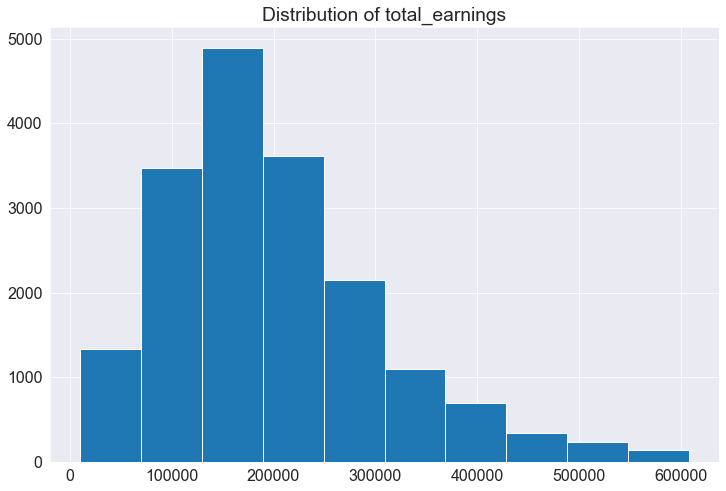

yearsofexperience
count    17967.000000
mean         7.081371
std          5.721208
min          0.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         45.000000
Name: yearsofexperience, dtype: float64
--------------------------


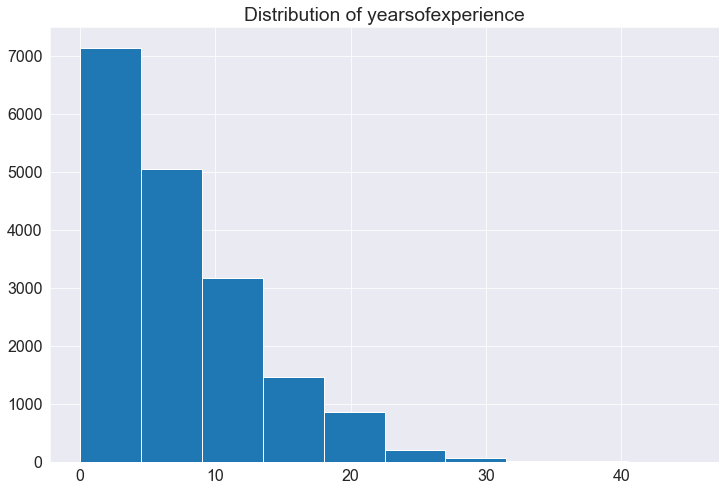

yearsatcompany
count    17967.000000
mean         2.665587
std          3.255595
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max         40.000000
Name: yearsatcompany, dtype: float64
--------------------------


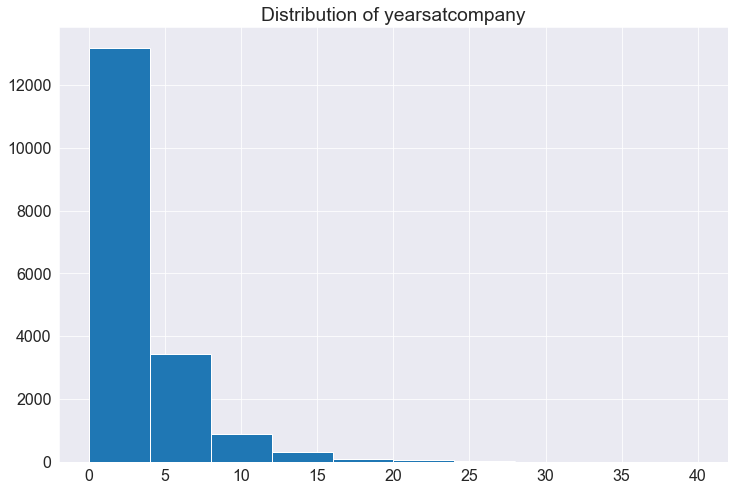

cityid
count    17967.000000
mean     10081.575778
std       7455.946492
min       1153.000000
25%       7351.000000
50%       8036.000000
75%      11521.000000
max      47926.000000
Name: cityid, dtype: float64
--------------------------


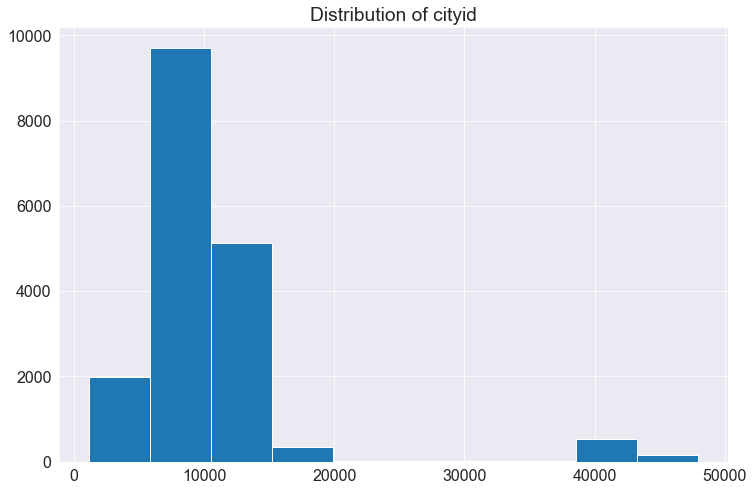

masters_degree
count    17967.000000
mean         0.502922
std          0.500005
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: masters_degree, dtype: float64
--------------------------


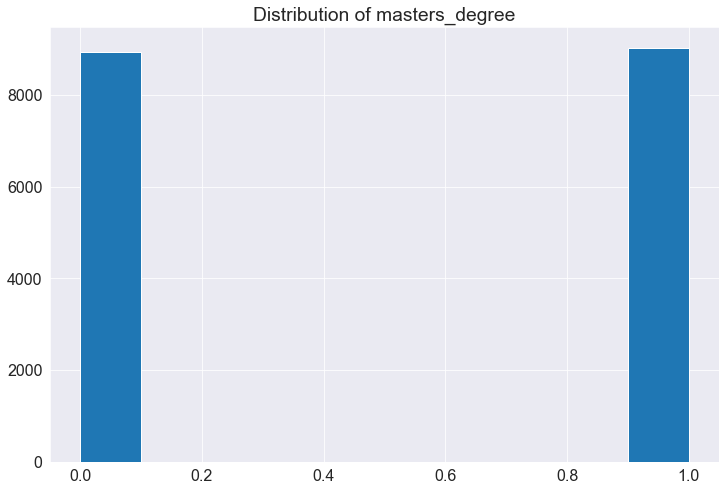

bachelors_degree
count    17967.000000
mean         0.422274
std          0.493935
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: bachelors_degree, dtype: float64
--------------------------


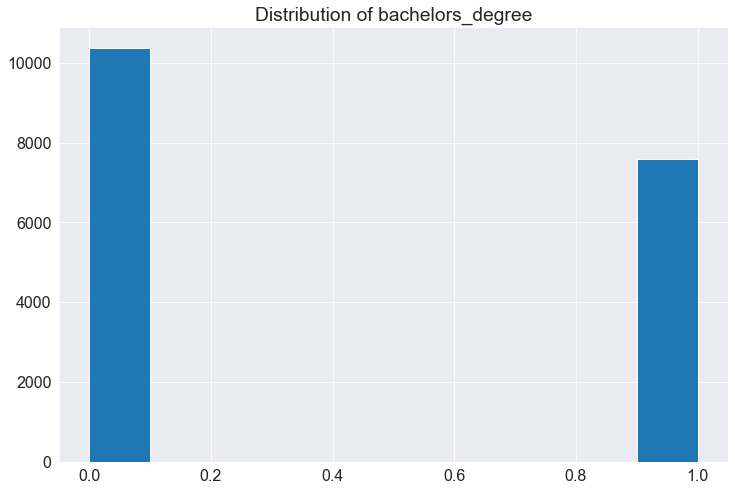

doctorate_degree
count    17967.000000
mean         0.055658
std          0.229266
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: doctorate_degree, dtype: float64
--------------------------


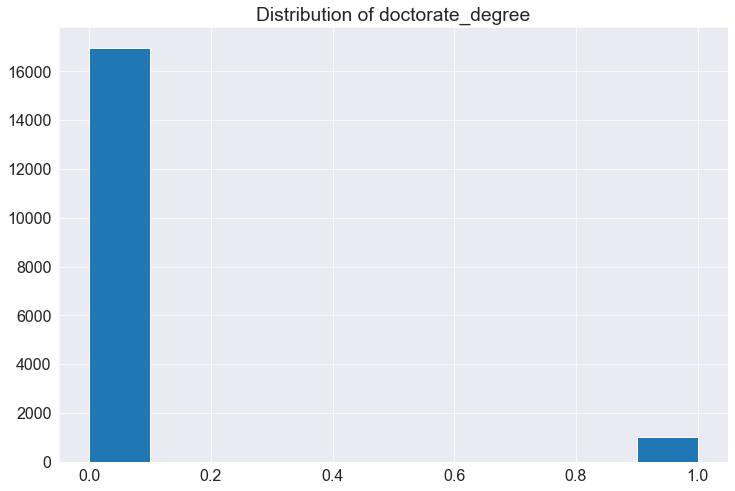

highschool
count    17967.000000
mean         0.010798
std          0.103352
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: highschool, dtype: float64
--------------------------


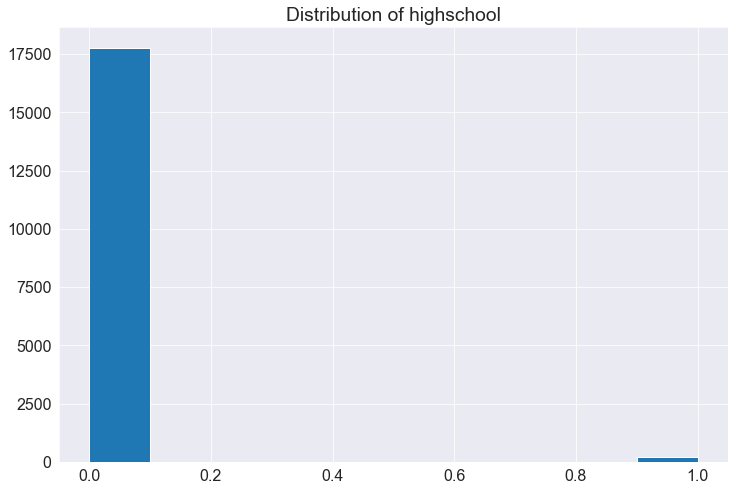

some_college
count    17967.000000
mean         0.010853
std          0.103615
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: some_college, dtype: float64
--------------------------


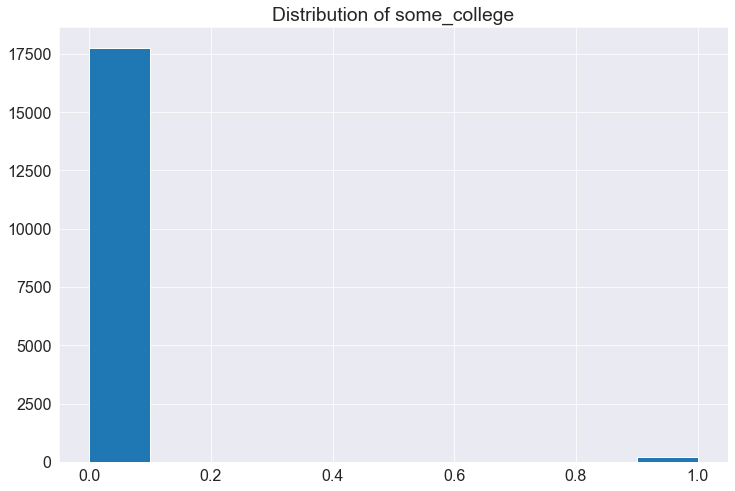

title_business_analyst
count    17967.000000
mean         0.016308
std          0.126659
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_business_analyst, dtype: float64
--------------------------


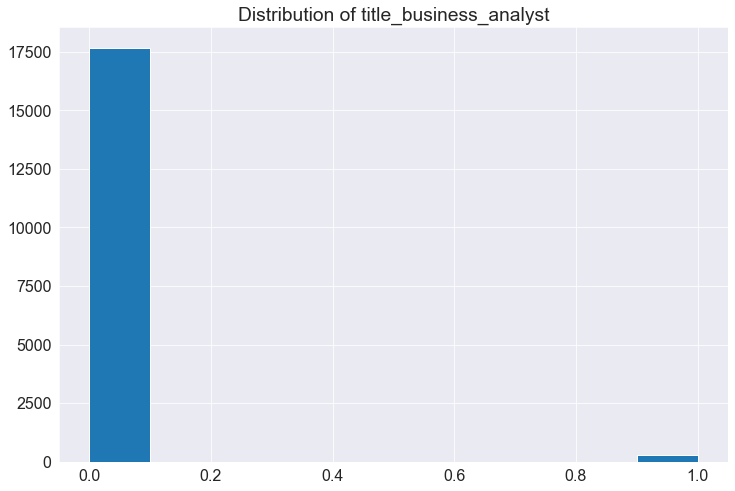

title_data_scientist
count    17967.000000
mean         0.046363
std          0.210275
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_data_scientist, dtype: float64
--------------------------


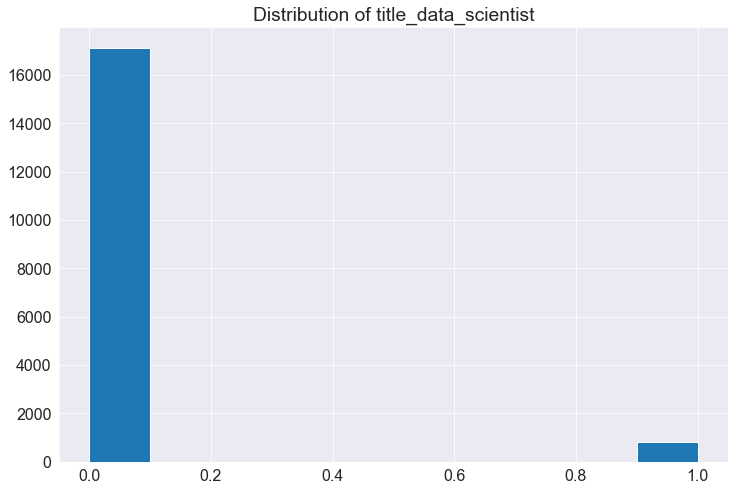

title_hardware_engineer
count    17967.000000
mean         0.043246
std          0.203416
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_hardware_engineer, dtype: float64
--------------------------


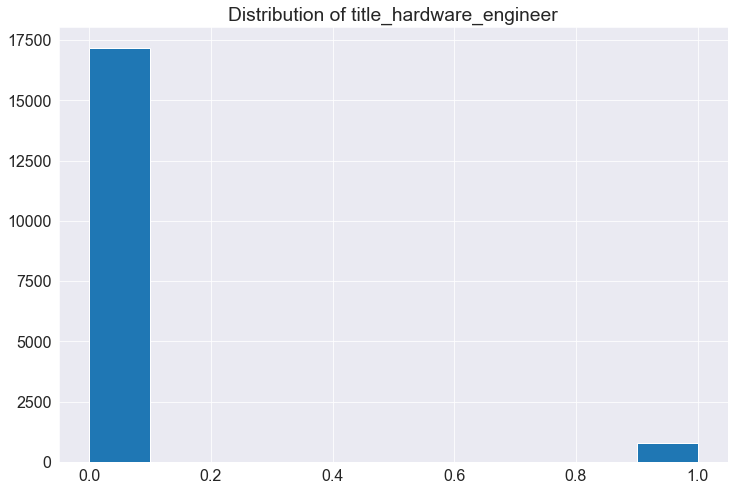

title_human_resources
count    17967.000000
mean         0.007069
std          0.083779
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_human_resources, dtype: float64
--------------------------


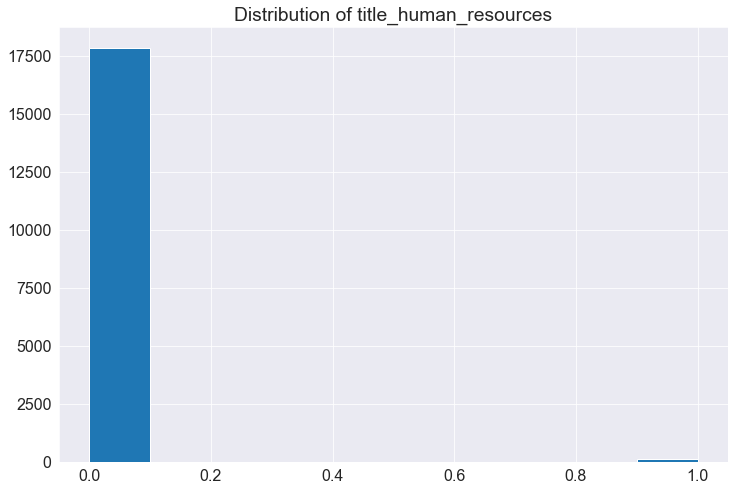

title_management_consultant
count    17967.000000
mean         0.019202
std          0.137238
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_management_consultant, dtype: float64
--------------------------


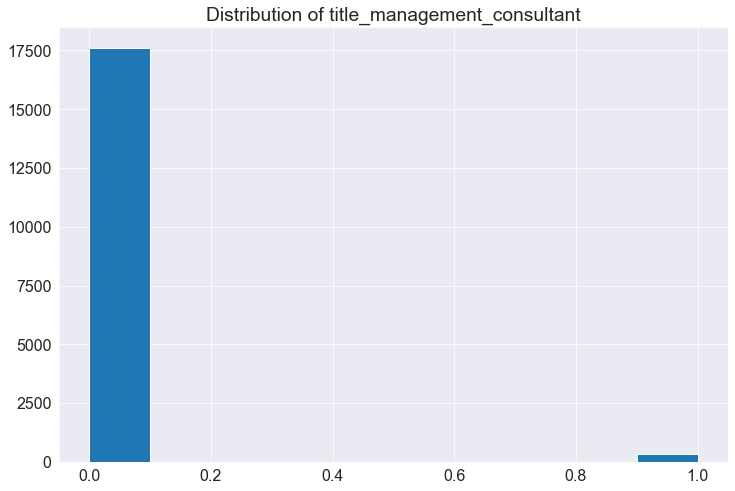

title_marketing
count    17967.000000
mean         0.013580
std          0.115744
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_marketing, dtype: float64
--------------------------


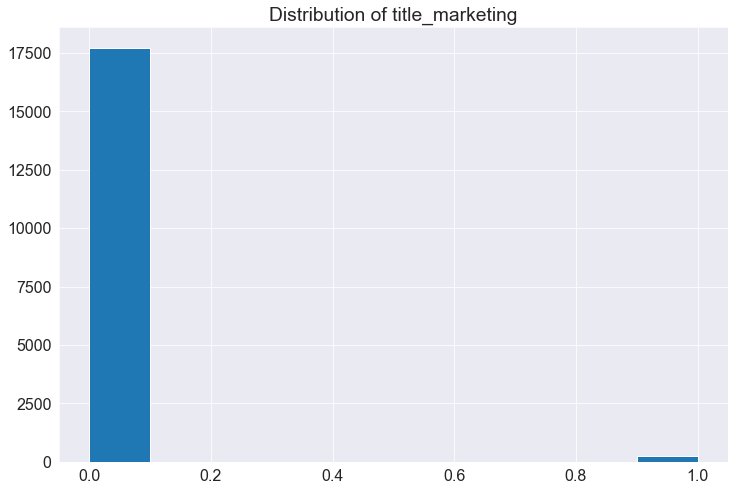

title_mechanical_engineer
count    17967.000000
mean         0.009740
std          0.098213
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_mechanical_engineer, dtype: float64
--------------------------


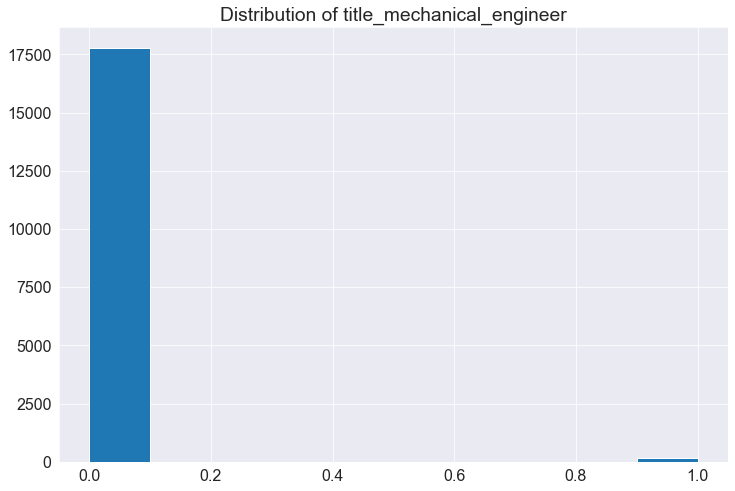

title_product_designer
count    17967.000000
mean         0.026159
std          0.159613
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_product_designer, dtype: float64
--------------------------


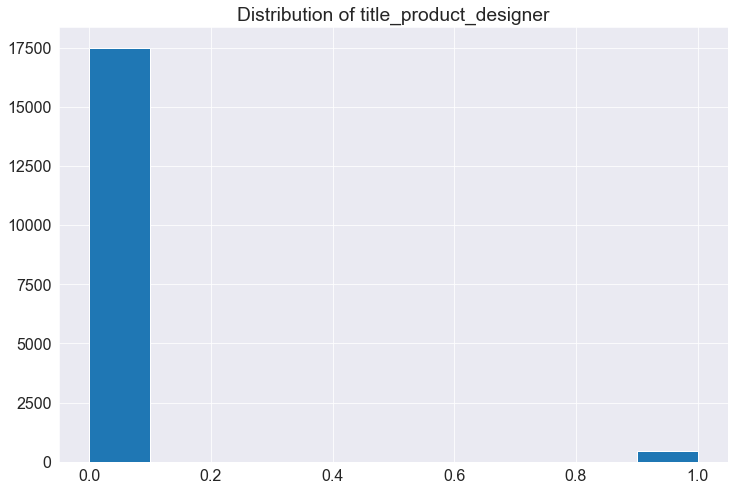

title_product_manager
count    17967.000000
mean         0.072244
std          0.258898
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_product_manager, dtype: float64
--------------------------


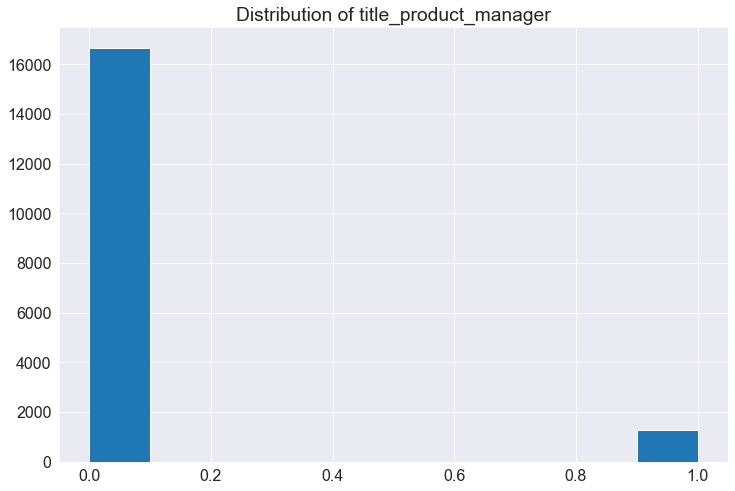

title_recruiter
count    17967.000000
mean         0.008794
std          0.093365
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_recruiter, dtype: float64
--------------------------


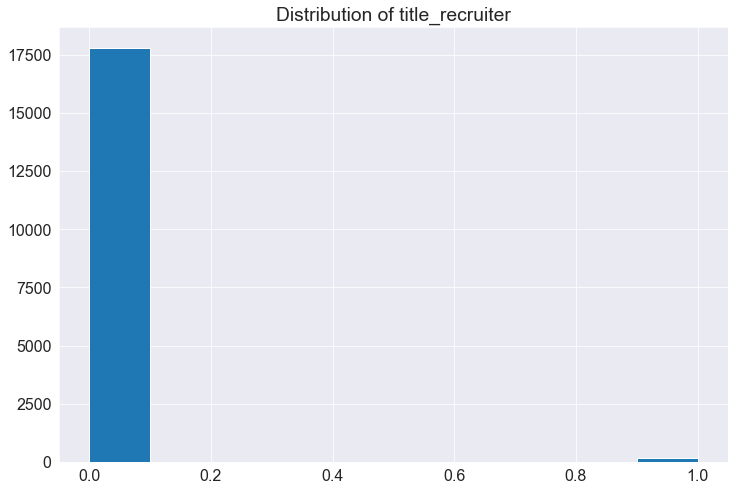

title_sales
count    17967.000000
mean         0.008460
std          0.091591
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_sales, dtype: float64
--------------------------


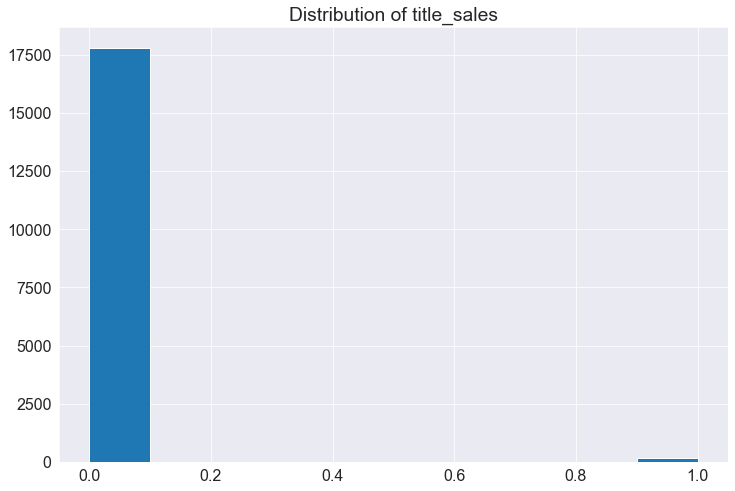

title_software_engineer
count    17967.000000
mean         0.635832
std          0.481209
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: title_software_engineer, dtype: float64
--------------------------


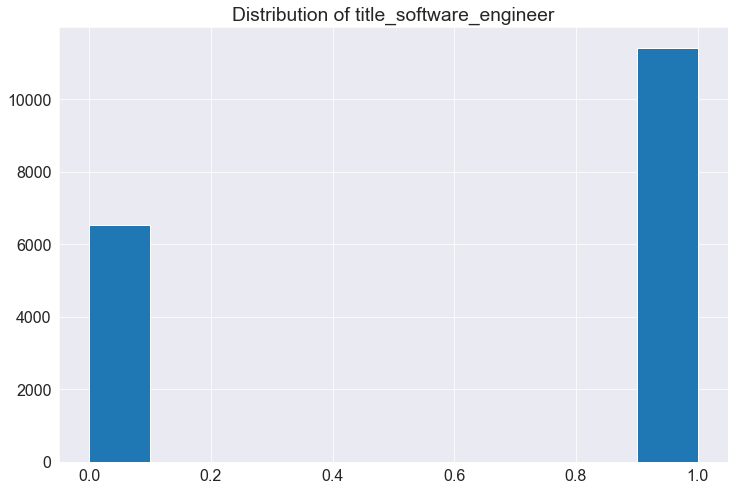

title_software_engineering_manager
count    17967.000000
mean         0.047587
std          0.212897
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_software_engineering_manager, dtype: float64
--------------------------


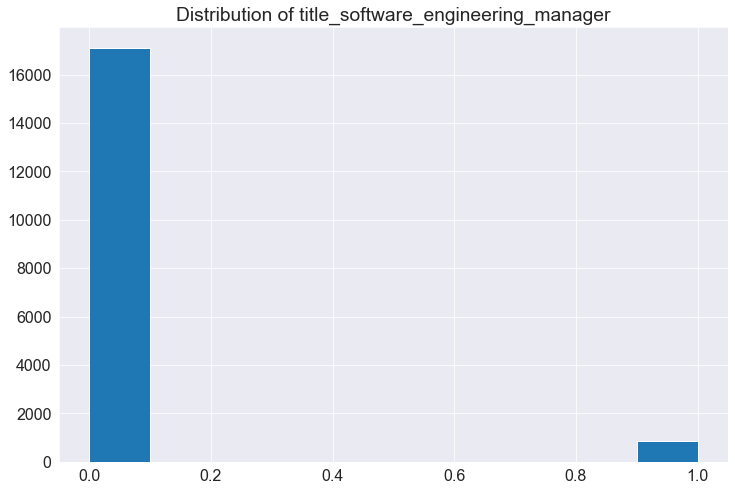

title_solution_architect
count    17967.000000
mean         0.017755
std          0.132063
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_solution_architect, dtype: float64
--------------------------


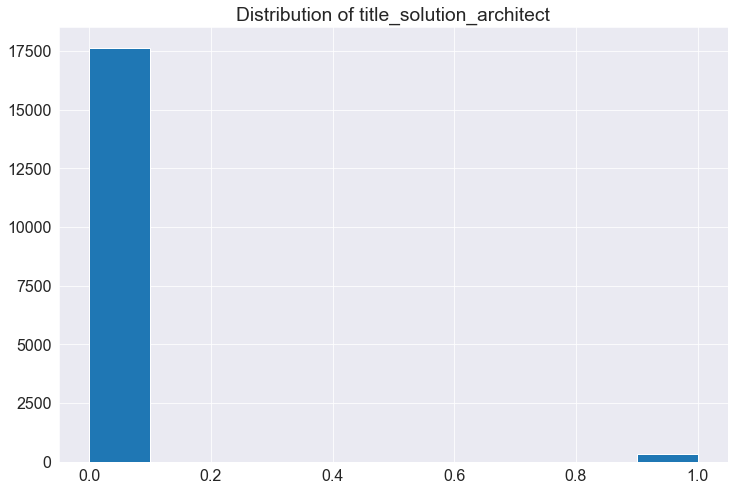

title_technical_program_manager
count    17967.000000
mean         0.027662
std          0.164007
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: title_technical_program_manager, dtype: float64
--------------------------


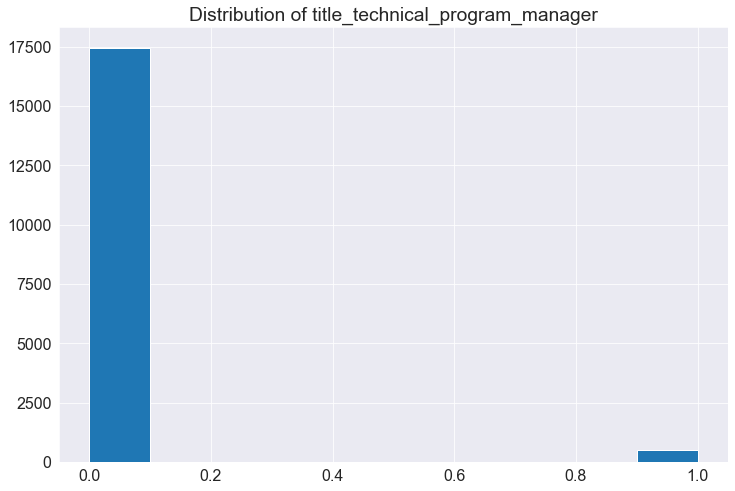

highly_experienced
count    17967.000000
mean         0.686036
std          0.464115
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: highly_experienced, dtype: float64
--------------------------


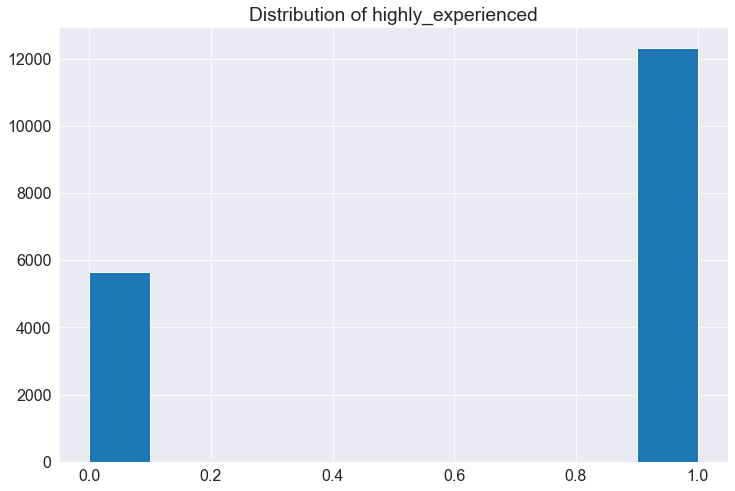

In [18]:
plot_hist(train,col_list)

**Takeaways**
- Years of experience and years at company are right skewed
- A majority of the titles have very few entries.
- mean years of experience is almost 5 more years then the mean years at company.

### Bivariate exploration

In [19]:
categorical = ['highly_experienced','title_data_scientist','masters_degree','bachelors_degree','doctorate_degree','highschool','some_college']

In [20]:
continuous = ['total_earnings']

In [21]:
#plot_categorical_and_continuous_vars(train,categorical,continuous)

### Multivariate exploration

In [22]:
X_train_scaled.columns

Index(['yearsofexperience', 'yearsatcompany', 'cityid', 'masters_degree',
       'bachelors_degree', 'doctorate_degree', 'highschool', 'some_college',
       'title_business_analyst', 'title_data_scientist',
       'title_hardware_engineer', 'title_human_resources',
       'title_management_consultant', 'title_marketing',
       'title_mechanical_engineer', 'title_product_designer',
       'title_product_manager', 'title_recruiter', 'title_sales',
       'title_software_engineer', 'title_software_engineering_manager',
       'title_solution_architect', 'title_technical_program_manager',
       'highly_experienced'],
      dtype='object')

### Modeling

In [23]:
# These are the columns that are going to be used in the modeling.
cols = ["yearsofexperience","highly_experienced","doctorate_degree","bachelors_degree","cityid"]
X_train_scaled = X_train_scaled[cols]
X_validate_scaled = X_validate_scaled[cols]
X_test_scaled = X_test_scaled[cols]

In [24]:
# Putting my y values into a dataframe so we can append information.
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [25]:
# lets make dataframes that will hold the rmse and R2 of the models for the train data.
metric_df_train = pd.DataFrame()

In [26]:
# lets get the mean baseline
total_earnings_pred_mean = y_train.total_earnings.mean()
y_train['total_earnings_pred_mean'] = total_earnings_pred_mean
# lets get the median baseline
total_earnings_pred_median = y_train.total_earnings.median()
y_train['total_earnings_pred_median'] = total_earnings_pred_median

In [27]:
metric_df_train = make_metric_df_train(y_train.total_earnings, y_train.total_earnings_pred_mean, "mean_baseline", metric_df_train)
metric_df_train = make_metric_df_train(y_train.total_earnings, y_train.total_earnings_pred_median, "median_baseline", metric_df_train)

In [28]:
# lets take a look at our rmse and r2
metric_df_train

,model,RMSE_train,r^2_train
0,mean_baseline,106825.088516,0.0
1,median_baseline,108352.232148,0.0


**Now lets start making the models**

**Linear Regression Train**

In [29]:
# Created a linear regression model and appended the data into our metric_df dataframe
lm = LinearRegression(normalize=True)
# fitting the data
lm.fit(X_train_scaled, y_train.total_earnings)
#Predicting the values
y_train['total_earnings_pred_lm'] = lm.predict(X_train_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_train = make_metric_df_train(y_train.total_earnings, y_train.total_earnings_pred_lm, "lm_model", metric_df_train)
metric_df_train

,model,RMSE_train,r^2_train
0,mean_baseline,106825.088516,0.000000
1,median_baseline,108352.232148,0.000000
2,lm_model,93994.923345,0.225784


**Polynomial Regression Train**

In [30]:
# creating polynomial features
pf = PolynomialFeatures(degree = 3)
# fitting the features onto the data
X_train_degree3 = pf.fit_transform(X_train_scaled)
# Creating the model for the polynomial data
lm3 = LinearRegression(normalize = True)
# fitting the data
lm3.fit(X_train_degree3, y_train.total_earnings)
#Predicting the values
y_train['total_earnings_pred_poly'] = lm3.predict(X_train_degree3)
# appending the RMSE and R^2 to dataframe
metric_df_train = make_metric_df_train(y_train.total_earnings, y_train.total_earnings_pred_poly, "poly_model", metric_df_train)
metric_df_train

,model,RMSE_train,r^2_train
0,mean_baseline,106825.088516,0.000000
1,median_baseline,108352.232148,0.000000
2,lm_model,93994.923345,0.225784
3,poly_model,90325.449953,0.285053


**Lasso Lars Train**

In [31]:
# Created a lasso lars regression model and appended the data into our metric_df dataframe
lars = LassoLars(alpha=1)
# fitting the data
lars.fit(X_train_scaled, y_train.total_earnings)
# predicting the values
y_train['total_earnings_pred_lars'] = lars.predict(X_train_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_train = make_metric_df_train(y_train.total_earnings, y_train.total_earnings_pred_lars, "lars_model", metric_df_train)
metric_df_train

,model,RMSE_train,r^2_train
0,mean_baseline,106825.088516,0.000000
1,median_baseline,108352.232148,0.000000
2,lm_model,93994.923345,0.225784
3,poly_model,90325.449953,0.285053
4,lars_model,93995.263844,0.225778


**Tweedie Regressor Train**

In [32]:
# Created a Tweedie regressor model and appended the data into our metric_df dataframe
glm = TweedieRegressor(power=1, alpha=0)
# fitting the data
glm.fit(X_train_scaled, y_train.total_earnings)
# predicting the values
y_train['total_earnings_pred_glm'] = glm.predict(X_train_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_train = make_metric_df_train(y_train.total_earnings, y_train.total_earnings_pred_glm, "tweedie_model", metric_df_train)
metric_df_train

,model,RMSE_train,r^2_train
0,mean_baseline,106825.088516,0.000000
1,median_baseline,108352.232148,0.000000
2,lm_model,93994.923345,0.225784
3,poly_model,90325.449953,0.285053
4,lars_model,93995.263844,0.225778
5,tweedie_model,94704.296351,0.214054


**Decision Tree Regression Train**

In [33]:
# Created a Decision Tree regressor model and appended the data into our metric_df dataframe
tree = DecisionTreeRegressor(max_depth = 4)
# fitting the data
tree.fit(X_train_scaled, y_train.total_earnings)
# predicting the values
y_train['total_earnings_tree_reg'] = tree.predict(X_train_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_train = make_metric_df_train(y_train.total_earnings, y_train.total_earnings_tree_reg, "decision_tree_model", metric_df_train)
metric_df_train

,model,RMSE_train,r^2_train
0,mean_baseline,106825.088516,0.000000
1,median_baseline,108352.232148,0.000000
2,lm_model,93994.923345,0.225784
3,poly_model,90325.449953,0.285053
4,lars_model,93995.263844,0.225778
5,tweedie_model,94704.296351,0.214054
6,decision_tree_model,83847.590794,0.383923


### Validate

In [34]:
metric_df_validate = pd.DataFrame()

In [35]:
y_validate["total_earnings_pred_mean"] = total_earnings_pred_mean
y_validate["total_earnings_pred_median"] = total_earnings_pred_median

metric_df_validate = make_metric_df(y_validate.total_earnings, y_validate.total_earnings_pred_mean, "mean_baseline", metric_df_validate)
metric_df_validate = make_metric_df(y_validate.total_earnings, y_validate.total_earnings_pred_median, "median_baseline", metric_df_validate)

In [36]:
metric_df_validate

,model,RMSE_validate,r^2_validate
0,mean_baseline,105455.289004,0.0
1,median_baseline,106840.889279,0.0


**Linear Regression Validate**

In [37]:
# testing the model on validation
y_validate['total_earnings_pred_lm'] = lm.predict(X_validate_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_validate = make_metric_df(y_validate.total_earnings, y_validate.total_earnings_pred_lm, "lm_model", metric_df_validate)
metric_df_validate

,model,RMSE_validate,r^2_validate
0,mean_baseline,105455.289004,0.000000
1,median_baseline,106840.889279,0.000000
2,lm_model,93387.603714,0.216108


**Polynomial Regression Validate**

In [38]:
X_validate_degree3 = pf.transform(X_validate_scaled)

y_validate['total_earnings_pred_poly'] = lm3.predict(X_validate_degree3)
# appending the RMSE and R^2 to dataframe
metric_df_validate = make_metric_df(y_validate.total_earnings, y_validate.total_earnings_pred_poly, "poly_model", metric_df_validate)
metric_df_validate

,model,RMSE_validate,r^2_validate
0,mean_baseline,105455.289004,0.000000
1,median_baseline,106840.889279,0.000000
2,lm_model,93387.603714,0.216108
3,poly_model,89849.259105,0.274297


**Lasso Lars Validate**

In [39]:
# testing the model on validation
y_validate['total_earnings_pred_lars'] = lars.predict(X_validate_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_validate = make_metric_df(y_validate.total_earnings, y_validate.total_earnings_pred_lars, "lars_model", metric_df_validate)
metric_df_validate

,model,RMSE_validate,r^2_validate
0,mean_baseline,105455.289004,0.000000
1,median_baseline,106840.889279,0.000000
2,lm_model,93387.603714,0.216108
3,poly_model,89849.259105,0.274297
4,lars_model,93377.767510,0.216271


**Tweedie Regressor Validate**

In [40]:
# testing the model on validation
y_validate['total_earnings_pred_glm'] = glm.predict(X_validate_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_validate = make_metric_df(y_validate.total_earnings, y_validate.total_earnings_pred_glm, "tweedie_model", metric_df_validate)
metric_df_validate

,model,RMSE_validate,r^2_validate
0,mean_baseline,105455.289004,0.000000
1,median_baseline,106840.889279,0.000000
2,lm_model,93387.603714,0.216108
3,poly_model,89849.259105,0.274297
4,lars_model,93377.767510,0.216271
5,tweedie_model,94114.872846,0.203897


**Decision Tree Regression Validate**

In [41]:
# testing the model on validation
y_validate['total_earnings_pred_tree'] = tree.predict(X_validate_scaled)
# appending the RMSE and R^2 to dataframe
metric_df_validate = make_metric_df(y_validate.total_earnings, y_validate.total_earnings_pred_tree, "decision_tree_model", metric_df_validate)
metric_df_validate

,model,RMSE_validate,r^2_validate
0,mean_baseline,105455.289004,0.000000
1,median_baseline,106840.889279,0.000000
2,lm_model,93387.603714,0.216108
3,poly_model,89849.259105,0.274297
4,lars_model,93377.767510,0.216271
5,tweedie_model,94114.872846,0.203897
6,decision_tree_model,83293.430408,0.376124


### Test

In [43]:
# Getting the baseline on the test data or unseen data, mean outperformed median so only mean will be used.
y_test['total_earnings_pred_mean'] = total_earnings_pred_mean